In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [ ]:
# I could easily use the boxscores from in the db instead of pulling from ESPN

In [2]:
league_id = 84057
# I am team 10

In [3]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%('docker','docker',dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [4]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "kona_player_info"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()
data.keys()

dict_keys(['players'])

In [19]:
stat_list = []
team_id_list = []
injured_list = []
injuryStatus_list = []
for player in data['players']:
    #print(player['player']['fullName'])
    for stat_item in player['player']['stats']:
        #looks like season totals AND averages id = '002020'
        if stat_item['id'] == '002020':
            if '40' in stat_item['stats'].keys(): # '40' is minutes
                stat_item['stats']['playerName'] = player['player']['fullName']
                stat_list.append(stat_item['stats'])
                team_id_list.append(player['onTeamId'])
                injured_list.append(player['player']['injured'])
                injuryStatus_list.append(player['player']['injuryStatus'])

In [20]:
stats_df = pd.DataFrame(stat_list)
stats_df['onTeamId'] = team_id_list
stats_df['injured'] = injured_list
stats_df['injuryStatus'] = injuryStatus_list
stats_df.shape

(463, 48)

In [21]:
col_rename_dict = {'0':'pts', '1':'blocks', '2':'steals', '3':'ast', '6':'reb', '13':'fgm', '14': 'fga', 
                   '15': 'ftm', '16':'fta', '17':'threes', '40':'min', '42':'gp'}
stats_df.rename(columns=col_rename_dict, inplace=True)
stats_df['fg_pct'] = stats_df['fgm'] / stats_df['fga']
stats_df['ft_pct'] = stats_df['ftm'] / stats_df['fta']
stats_df = stats_df[['playerName','onTeamId','injuryStatus','pts','blocks','steals','ast','reb','fgm','fga','fg_pct','ftm','fta','ft_pct','threes','min','gp']]

In [22]:
stats_df.head()

,playerName,onTeamId,injuryStatus,pts,blocks,steals,ast,reb,fgm,fga,fg_pct,ftm,fta,ft_pct,threes,min,gp
0,Vince Carter,0,ACTIVE,177.0,15.0,13.0,33.0,67.0,63.0,189.0,0.333333,15.0,21.0,0.714286,36.0,549.0,36.0
1,Tyson Chandler,0,ACTIVE,34.0,8.0,6.0,6.0,66.0,14.0,18.0,0.777778,6.0,13.0,0.461538,0.0,221.0,25.0
2,LeBron James,6,ACTIVE,1020.0,20.0,52.0,436.0,306.0,391.0,795.0,0.491824,153.0,221.0,0.692308,85.0,1396.0,40.0
3,Carmelo Anthony,12,ACTIVE,472.0,16.0,27.0,38.0,179.0,179.0,408.0,0.438725,71.0,86.0,0.825581,43.0,926.0,29.0
4,Kyle Korver,0,ACTIVE,239.0,7.0,17.0,45.0,70.0,77.0,185.0,0.416216,22.0,26.0,0.846154,63.0,630.0,38.0


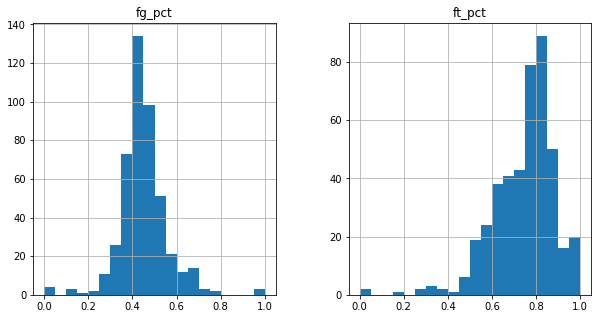

In [46]:
stats_df[['ft_pct', 'fg_pct']].hist(bins=20, figsize=(10,5));

In [24]:
stats_df.loc[:,'ast_rank'] = stats_df.apply(lambda x: ( (x['ast'] - stats_df['ast'].mean()) / stats_df['ast'].std()) , axis = 1)
stats_df.loc[:,'blocks_rank'] = stats_df.apply(lambda x: ( (x['blocks'] - stats_df['blocks'].mean()) / stats_df['blocks'].std()) , axis = 1)
stats_df.loc[:,'steals_rank'] = stats_df.apply(lambda x: ( (x['steals'] - stats_df['steals'].mean()) / stats_df['steals'].std()) , axis = 1)
stats_df.loc[:,'reb_rank'] = stats_df.apply(lambda x: ( (x['reb'] - stats_df['reb'].mean()) / stats_df['reb'].std()) , axis = 1)
stats_df.loc[:,'pts_rank'] = stats_df.apply(lambda x: ( (x['pts'] - stats_df['pts'].mean()) / stats_df['pts'].std()) , axis = 1)
stats_df.loc[:,'threes_rank'] = stats_df.apply(lambda x: ( (x['threes'] - stats_df['threes'].mean()) / stats_df['threes'].std()) , axis = 1)
stats_df.loc[:,'fta_rank'] = stats_df.apply(lambda x: ( (x['fta'] - stats_df['fta'].mean()) / stats_df['fta'].std()) , axis = 1)
stats_df.loc[:,'fga_rank'] = stats_df.apply(lambda x: ( (x['fga'] - stats_df['fga'].mean()) / stats_df['fga'].std()) , axis = 1)
stats_df.loc[:,'ft_pct_rank'] = stats_df.apply(lambda x: ( (x['ft_pct'] - stats_df['ft_pct'].mean()) / stats_df['ft_pct'].std()) , axis = 1)
stats_df.loc[:,'fg_pct_rank'] = stats_df.apply(lambda x: ( (x['fg_pct'] - stats_df['fg_pct'].mean()) / stats_df['fg_pct'].std()) , axis = 1)
stats_df['fg_rank_adj'] = stats_df['fg_pct_rank'] * stats_df['fga_rank']
stats_df['ft_rank_adj'] = stats_df['ft_pct_rank'] * stats_df['fta_rank']

cat_ranks = ['ast_rank','blocks_rank','steals_rank','reb_rank','pts_rank','threes_rank','fg_rank_adj','ft_rank_adj']
stats_df['total_rank'] = stats_df[cat_ranks].sum(axis=1)
stats_df.sort_values('total_rank', inplace=True, ascending= False)

final_stats_df = stats_df[['playerName','onTeamId','injuryStatus','total_rank'] + cat_ranks]

In [25]:
# how to properly account for fga and fta in their ranks? Did what I did make sense? doesn't appear to match up well with website
# do I need to remove anyone when I calculate the ranks?

In [26]:
my_team = final_stats_df.loc[final_stats_df.onTeamId==10]
my_team

,playerName,onTeamId,injuryStatus,total_rank,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj
221,Giannis Antetokounmpo,10,ACTIVE,11.927030,2.271277,1.799299,1.524974,3.837570,3.528096,1.043472,2.738518,-4.816176
264,Nikola Jokic,10,ACTIVE,11.146606,2.828337,0.630459,0.998628,2.682555,1.842847,0.629785,1.003228,0.530767
193,Buddy Hield,10,ACTIVE,7.506917,0.928619,-0.107756,0.764697,0.821167,2.063489,3.436948,-0.667651,0.267403
119,Tomas Satoransky,10,ACTIVE,5.726719,2.442680,-0.476863,2.168284,0.334343,0.534211,0.422941,-0.003411,0.304534
252,Julius Randle,10,ACTIVE,5.519556,0.985753,-0.292310,0.647732,2.415279,1.793393,0.570687,0.044751,-0.645728
46,Derrick Rose,10,ACTIVE,5.108314,2.185575,-0.046238,0.530766,-0.352939,1.424388,0.068352,0.763818,0.534592
393,Miles Bridges,10,ACTIVE,4.715788,0.214439,1.184120,0.355318,1.136171,0.899412,0.925276,-0.052474,0.053527
190,Taurean Prince,10,ACTIVE,4.694501,0.257290,0.199834,0.940146,1.355720,0.758657,2.018592,-0.771249,-0.064488
432,PJ Washington,10,ACTIVE,4.615434,0.185872,1.307156,0.940146,0.859350,0.686378,0.659334,0.194504,-0.217305
399,Markelle Fultz,10,ACTIVE,4.019338,1.814202,-0.353828,1.875870,0.200705,0.758657,-0.404433,0.143033,-0.014869


In [27]:
my_team[cat_ranks].sum()

ast_rank       13.300433
blocks_rank     9.487841
steals_rank    12.163411
reb_rank       14.970685
pts_rank       15.180782
threes_rank     9.635108
fg_rank_adj     2.116241
ft_rank_adj    -3.760172
dtype: float64

In [28]:
team_stats_list = []
for team_id in range(1, 13):
    team_stats = final_stats_df.loc[(final_stats_df.onTeamId==team_id) & (final_stats_df.injuryStatus!= 'OUT')]
    print(team_stats.shape)
    team_stats_list.append(team_stats[cat_ranks].sum())

(13, 12)
(11, 12)
(12, 12)
(11, 12)
(13, 12)
(12, 12)
(12, 12)
(12, 12)
(13, 12)
(13, 12)
(13, 12)
(13, 12)


In [34]:
team_rater = pd.concat(team_stats_list, axis=1).transpose()
team_ranks = team_rater.rank(ascending=False)
team_rater['teamId'] = list(range(1,13))
team_ranks['teamId'] = list(range(1,13))

In [35]:
team_rater

,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj,teamId
0,13.114746,10.841235,14.444239,10.837449,10.246769,4.877705,1.670076,4.872832,1
1,3.258696,10.749157,4.668771,12.497885,10.235906,4.386412,0.918247,-1.075670,2
2,13.957293,7.565506,7.070987,9.262181,12.246137,6.789142,1.324528,3.560367,3
3,9.014984,5.089510,5.662979,9.032839,14.062905,10.739466,1.818330,5.223506,4
4,18.428243,6.965607,10.818306,9.348338,14.138438,9.723756,1.115766,4.661047,5
5,12.986009,4.182021,10.813885,8.565353,10.191883,11.221505,0.909405,0.862868,6
6,8.115303,3.997468,9.936643,8.813538,10.846201,10.423680,0.369775,6.370532,7
7,3.587403,20.422747,10.112092,10.541288,9.971241,6.464102,1.494000,0.036852,8
8,8.886802,3.766676,8.654443,10.283805,12.529273,8.512243,1.666422,6.982837,9
9,13.300433,9.487841,12.163411,14.970685,15.180782,9.635108,2.116241,-3.760172,10


In [53]:
next_macthup_ranks = team_ranks.loc[team_ranks.teamId.isin([10,5])]
next_macthup_ranks

,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj,teamId
4,1.0,6.0,3.0,7.0,4.0,4.0,9.0,6.0,5
9,3.0,4.0,2.0,1.0,2.0,5.0,1.0,12.0,10


In [54]:
next_macthup_ranks.diff()

,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj,teamId
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.0,-2.0,-1.0,-6.0,-2.0,1.0,-8.0,6.0,5.0


In [55]:
next_macthup_rater = team_rater.loc[team_rater.teamId.isin([10,5])]
next_macthup_rater

,ast_rank,blocks_rank,steals_rank,reb_rank,pts_rank,threes_rank,fg_rank_adj,ft_rank_adj,teamId
4,18.428243,6.965607,10.818306,9.348338,14.138438,9.723756,1.115766,4.661047,5
9,13.300433,9.487841,12.163411,14.970685,15.180782,9.635108,2.116241,-3.760172,10
